### Importing libraries

In [311]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

### Configuring hardware

In [312]:
physical_devices = tf.config.list_physical_devices()

print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [313]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

### Loading data

##### Processed dataset with pre-selecter features (by Random Forest)

In [314]:
# data_train = pd.read_csv('data/processed/train_meaningfull.csv')
# data_test = pd.read_csv('data/processed/test_meaningfull.csv')

##### Raw dataset with (>500 features)

In [315]:
data_train = pd.read_csv('data/raw/train.csv')
data_test = pd.read_csv('data/raw/test.csv')

##### Processing data

In [316]:
X_train = data_train.drop('Activity', axis='columns')
y_train = data_train['Activity']
y_train_encoded = pd.get_dummies(y_train)

In [317]:
X_test = data_test.drop('Activity', axis='columns')
y_test = data_test['Activity']
y_test_encoded = pd.get_dummies(y_test)

### Build model

In [318]:
from tensorflow import keras
from keras import regularizers
from keras import layers

regularizer = regularizers.l2(l=0.01)

model = keras.Sequential(
  [
    layers.Input(X_train.shape[-1]),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.4),
    layers.Dense(6, activation="sigmoid"),
  ]
)
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 128)               72064     
                                                                 
 dropout_64 (Dropout)        (None, 128)               0         
                                                                 
 dense_86 (Dense)            (None, 256)               33024     
                                                                 
 dropout_65 (Dropout)        (None, 256)               0         
                                                                 
 dense_87 (Dense)            (None, 256)               65792     
                                                                 
 dropout_66 (Dropout)        (None, 256)               0         
                                                                 
 dense_88 (Dense)            (None, 128)             

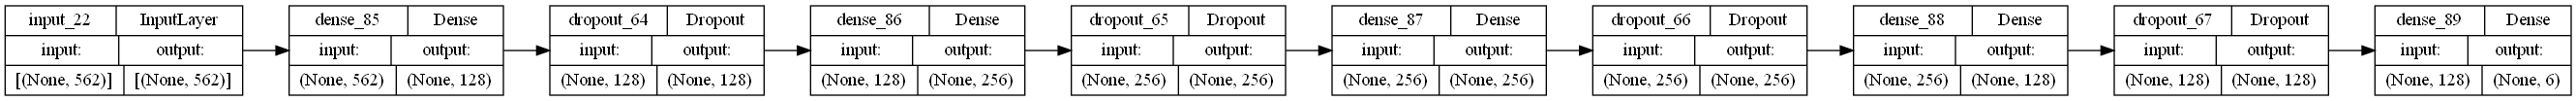

In [319]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [320]:
optimizer = keras.optimizers.Adadelta(learning_rate=1e-1, rho=0.95, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics='accuracy')

In [321]:
history = model.fit(
  X_train,
  y_train_encoded,
  batch_size=1000,
  epochs=300,
  verbose=1,
  validation_split=0.3
)

Epoch 1/300
6/6 [==============================] - 1s 88ms/step - loss: 10.0184 - accuracy: 0.1704 - val_loss: 9.8221 - val_accuracy: 0.1967
Epoch 2/300
6/6 [==============================] - 0s 14ms/step - loss: 9.9210 - accuracy: 0.1869 - val_loss: 9.7534 - val_accuracy: 0.1976
Epoch 3/300
6/6 [==============================] - 0s 13ms/step - loss: 9.8300 - accuracy: 0.2118 - val_loss: 9.6871 - val_accuracy: 0.2153
Epoch 4/300
6/6 [==============================] - 0s 13ms/step - loss: 9.7770 - accuracy: 0.2062 - val_loss: 9.6220 - val_accuracy: 0.2135
Epoch 5/300
6/6 [==============================] - 0s 13ms/step - loss: 9.7170 - accuracy: 0.2165 - val_loss: 9.5610 - val_accuracy: 0.2271
Epoch 6/300
6/6 [==============================] - 0s 13ms/step - loss: 9.6420 - accuracy: 0.2336 - val_loss: 9.4930 - val_accuracy: 0.2584
Epoch 7/300
6/6 [==============================] - 0s 13ms/step - loss: 9.5720 - accuracy: 0.2585 - val_loss: 9.4252 - val_accuracy: 0.2566
Epoch 8/300
6/6 [==

In [322]:
score = model.evaluate(X_test, y_test_encoded)[1]

print(score)

93/93 [==============================] - 0s 4ms/step - loss: 1.9120 - accuracy: 0.9121
0.9121140241622925


Text(0.5, 1.0, 'Accuracy Curves')

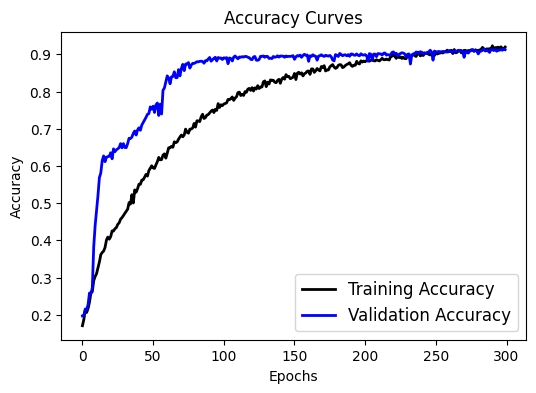

In [323]:
# Plotting the accuracy curve
plt.figure(figsize=[6, 4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)